# shape일정 X
- MNIST
- Pictures
- numbers_data2

-> 이것을 그대로 (28 by 28) 으로 줄이게 되면 손실이 너무 많이나 upscale 하여 진행
-> VGG16을 사용하기 위해 (150 by 150) 으로 upscale 하겠다

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
# label -> to_categorical
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

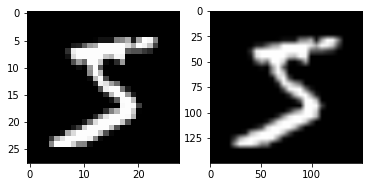

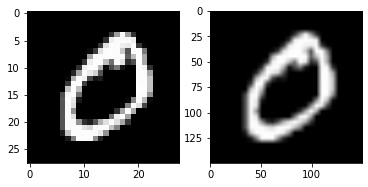

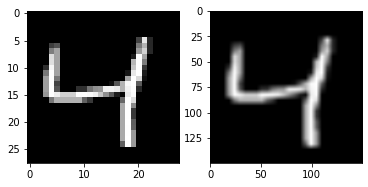

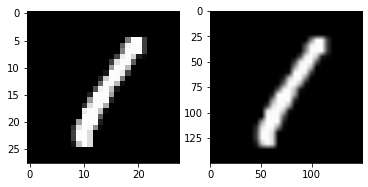

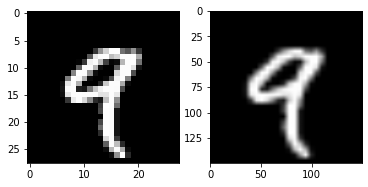

In [3]:
# (28, 28) -> (150, 150) 으로 Upscale 했을 때
for i in train_images[:5]:
    img = i
    img2 = cv2.resize(img, dsize=(150,150))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.show()

In [4]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000, 10), (10000, 10))

In [5]:
# mnist에서 제공해주는 test data 도 train data로 학습시키기 위해 concatenate
concat_train = np.concatenate((train_images, test_images), axis=0)
concat_labels = np.concatenate((train_labels, test_labels), axis=0)
concat_train.shape, concat_labels.shape

((70000, 28, 28), (70000, 10))

In [6]:
# (150, 150) 으로 Upscale 후 저장
train_images_150 = []
for i in concat_train:
    img = i
    img2 = cv2.resize(img, dsize=(150,150))
    train_images_150.append(img2)

In [7]:
train_images_150 = np.array(train_images_150)
train_images_150.shape

(70000, 150, 150)

In [8]:
# tf.keras.preprocessing.image_dataset_from_directory를 통해 directory에서 데이터 가져오기
train_dir = 'images/mnist_num/after_process/train'
test_dir = 'images/mnist_num/after_process/test'

import tensorflow as tf
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='categorical', color_mode='grayscale',
    image_size=(150,150), batch_size=98
)

for i, j in test_data.take(1):
    test_data_x = i
    test_data_y = j

test_data_x = np.squeeze(np.array(test_data_x))
test_data_y = np.array(test_data_y)

test_data_x.shape, test_data_y.shape

Found 98 files belonging to 10 classes.


((98, 150, 150), (98, 10))

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='categorical', color_mode='grayscale',
    image_size=(150,150), batch_size=245
)

for i, j in train_data.take(1):
    train_data_x = i
    train_data_y = j

train_data_x = np.squeeze(np.array(train_data_x))
train_data_y = np.array(train_data_y)

train_data_x.shape, train_data_y.shape

Found 245 files belonging to 10 classes.


((245, 150, 150), (245, 10))

In [10]:
train_images_150.shape, train_data_x.shape

((70000, 150, 150), (245, 150, 150))

In [11]:
# 모든 Train data 합쳐주기
concat_train_x = np.concatenate((train_images_150, train_data_x), axis=0)
concat_train_y = np.concatenate((concat_labels, train_data_y), axis=0)

# Data Normalization
concat_train_x = concat_train_x.astype('float32') / 255
test_data_x = test_data_x.astype('float32') / 255

concat_train_x.shape, concat_train_y.shape

((70245, 150, 150), (70245, 10))

In [12]:
# Train data Shuffle
from sklearn.utils import shuffle
X, y = shuffle(concat_train_x, concat_train_y)

In [13]:
train_x = X[:60000,:,:]
train_y = y[:60000,:]
validation_x = X[60000:,:,:]
validation_y = y[60000:,:]
train_x.shape, train_y.shape, validation_x.shape, validation_y.shape

((60000, 150, 150), (60000, 10), (10245, 150, 150), (10245, 10))

In [25]:
train_x = train_x.reshape(-1, 150, 150, 1)
validation_x = validation_x.reshape(-1, 150, 150, 1)
test_data_x = test_data_x.reshape(-1, 150, 150, 1)

# VGG16..
앞서 말한 대로 VGG16을 이용해 예제와 마찬가지로 Fine Tuning으로 진행 해보려고 하였으나..  
VGG16의 경우 3채널 데이터로 학습되었기 때문에 grayscale인 mnist데이터로는 불가능하다.

-> 직접 모델을 쌓아보기로 한다.
## 모델 쌓기 Plan
VGG16의 경우 *(Conv2D 두 번, MaxPooling2D 한 번) X 2 번*   
*(Conv2D 세 번, MaxPooling2D 한 번) X 3 번*으로 되어있다

우리는 단순한 데이터이기 때문에
*(Conv2D 한 번, MaxPooling2D 한 번) X 3 번*  으로 해보려고 한다.

In [15]:
from tensorflow.keras import models, layers

In [16]:
my_model = models.Sequential()
my_model.add(layers.Conv2D(64, (3,3), activation='relu', \
    padding='same', input_shape=(150,150,1)))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
my_model.add(layers.MaxPool2D((2,2)))
my_model.add(layers.Flatten())
my_model.add(layers.Dense(512, activation='relu'))
my_model.add(layers.Dense(10, activation='softmax'))

In [17]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0

In [18]:
train_x.shape

(60000, 150, 150, 1)

In [20]:
my_model.compile(optimizer='rmsprop', \
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = my_model.fit(train_x, train_y,\
    epochs=10, batch_size=100,
    validation_data=(validation_x, validation_y))

Epoch 1/10
600/600 [==============================] - 113s 174ms/step - loss: 0.0530 - accuracy: 0.9845 - val_loss: 0.0500 - val_accuracy: 0.9852
Epoch 2/10
600/600 [==============================] - 83s 139ms/step - loss: 0.0311 - accuracy: 0.9911 - val_loss: 0.0581 - val_accuracy: 0.9850
Epoch 3/10
600/600 [==============================] - 83s 139ms/step - loss: 0.0204 - accuracy: 0.9946 - val_loss: 0.0482 - val_accuracy: 0.9883
Epoch 4/10
600/600 [==============================] - 203s 339ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.0509 - val_accuracy: 0.9873
Epoch 5/10
600/600 [==============================] - 63s 106ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0801 - val_accuracy: 0.9869
Epoch 6/10
600/600 [==============================] - 59s 98ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.1007 - val_accuracy: 0.9880
Epoch 7/10
600/600 [==============================] - 56s 94ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.1007 - val_ac

In [21]:
my_model.save('my_model.h5')

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

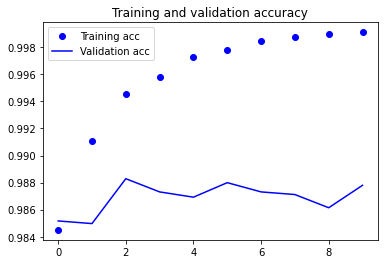

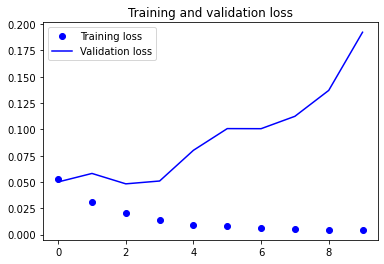

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
my_model.evaluate(test_data_x, test_data_y)

4/4 [==============================] - 1s 51ms/step - loss: 5.0325 - accuracy: 0.7959


[5.03251838684082, 0.795918345451355]